# Learning Curved Boundaries: Logistic Regression and a Tiny MLP

In this notebook we will build everything from the ground up using only NumPy.  Our goal is to train two different models on a challenging synthetic dataset and watch how they behave under three optimisers.  By the end you will understand why a hidden layer is needed, what each optimiser does, and how to interpret loss and accuracy curves.

The structure of the notebook follows a natural learning progression:

1. **Data preparation** – generate a two‑spiral dataset, split it into train/validation/test sets, and standardise the features.
2. **Model definitions** – implement logistic regression (a linear classifier) and a tiny multi‑layer perceptron from scratch.
3. **Optimisers** – implement three learning rules: plain stochastic gradient descent, SGD with momentum, and the adaptive optimiser Adam.
4. **Training loops** – write generic routines for iterating over mini‑batches, computing gradients, and updating parameters.
5. **Experiments** – train each model with each optimiser, track the loss and accuracy over epochs, and plot the results.

Throughout the notebook you will see both **code** (in executable cells) and **explanations** (in markdown).  Comments inside the code provide step‑by‑step insight into what each line does.

> ### Why spirals?
> A straight line can never cleanly separate two interleaved spirals; this forces the MLP to **bend** the input space.  Logistic regression will struggle here, so the difference between models will be striking. Also, it let's us build up from last weeks project.

Let's begin by generating the dataset.

## 1. Generating the two‑spiral dataset

The two spirals are generated by sampling a radius $r\in[0,1]$ and an angle $\theta$ that twists as $r$ increases.  One arm uses $(r\cos\theta, r\sin\theta)$ and the other arm is rotated by $\pi$, yielding $(r\cos(\theta+\pi), r\sin(\theta+\pi))$.  A small Gaussian perturbation adds realism.  We also define a reproducible random number generator to ensure that future runs produce the same points when using the same seed.



In [1]:
# Imports used throughout the notebook
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Iterator

def set_seed(seed: int = 1337) -> np.random.Generator:
    """
    Create a deterministic random number generator.  Using a single generator
    everywhere keeps experiments reproducible: the same seed means the same
    random numbers will be generated again.
    """
    # Seed the legacy random API for any third‑party code that still uses it
    np.random.seed(seed)
    # Return a Generator instance for modern code
    return np.random.default_rng(seed)

def make_spirals(
    n_per_class: int = 1500,
    noise: float = 0.08,
    turns: float = 1.75,
    rng: Optional[np.random.Generator] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a two‑spiral dataset.

    Parameters
    ----------
    n_per_class : int
        Number of points to generate for each spiral arm (class).
    noise : float
        Standard deviation of the isotropic Gaussian noise added to each point.
    turns : float
        How many half‑turns each spiral completes.  For example, 1.75 means
        $1.75\pi$ radians.
    rng : np.random.Generator or None
        Random number generator.  If None, a new default generator is created.

    Returns
    -------
    X : array of shape (2*n_per_class, 2)
        The 2‑D coordinates of all points.
    y : array of shape (2*n_per_class,)
        Integer labels (0 for the first arm, 1 for the second).
    """
    if rng is None:
        rng = np.random.default_rng()
    # Radii uniformly in [0,1]
    r = rng.random(n_per_class)
    # Angles proportional to radius create the spiral
    theta = turns * np.pi * r
    # Class 0 spiral (no rotation)
    x0 = r * np.cos(theta)
    y0 = r * np.sin(theta)
    # Class 1 spiral (rotated by π to interleave)
    x1 = r * np.cos(theta + np.pi)
    y1 = r * np.sin(theta + np.pi)
    # Stack the coordinates and add Gaussian noise
    X0 = np.stack([x0, y0], axis=1) + rng.normal(0.0, noise, size=(n_per_class, 2))
    X1 = np.stack([x1, y1], axis=1) + rng.normal(0.0, noise, size=(n_per_class, 2))
    X = np.vstack([X0, X1]).astype(np.float64)
    # Construct labels: 0 for the first arm, 1 for the second
    y = np.concatenate([
        np.zeros(n_per_class, dtype=np.int64),
        np.ones(n_per_class,  dtype=np.int64)
    ])
    return X, y

# Generate the data using a fixed seed for reproducibility
rng = set_seed(42)
X, y = make_spirals(n_per_class=1500, noise=0.08, turns=1.75, rng=rng)

print(f"Generated dataset X shape: {X.shape}, labels y shape: {y.shape}")


Generated dataset X shape: (3000, 2), labels y shape: (3000,)



The function `make_spirals` returns a matrix `X` of shape `(2 * n_per_class, 2)` containing the 2‑D coordinates and a vector `y` of length `2 * n_per_class` with integer labels `0` or `1`.  We used a single `rng` to ensure that the same random numbers are drawn on every run with the same seed.

## 2. Integrity checks

Before proceeding, it is important to **validate** that our data has the expected structure.  Catching problems early—such as mismatched shapes, wrong dtypes or missing values—saves hours of debugging later.  The following function performs a series of assertions to guarantee that the dataset is correctly formed.  Each assertion raises an informative error if it fails.



In [2]:
def assert_spiral_integrity(X: np.ndarray, y: np.ndarray) -> None:
    """
    Verify that the spiral dataset has consistent shapes, types and values.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (N, 2) and dtype float64.
    y : np.ndarray
        Label vector of shape (N,) and dtype int64 with labels {0,1}.

    Raises
    ------
    AssertionError
        If any condition is violated, an assertion error with a descriptive
        message is raised.
    """
    # X must be two‑dimensional with second dimension 2
    assert X.ndim == 2 and X.shape[1] == 2, f"X should be (N,2), got {X.shape}"
    # y must be one‑dimensional and have the same length as X
    assert y.ndim == 1 and y.shape[0] == X.shape[0], "y must be (N,) aligned with X"
    # Check dtypes to ensure numerical precision and correct integer representation
    assert X.dtype == np.float64, f"X dtype should be float64, got {X.dtype}"
    assert y.dtype == np.int64,   f"y dtype should be int64, got {y.dtype}"
    # Ensure labels are exactly {0,1}
    classes = np.unique(y)
    assert set(classes.tolist()) == {0,1}, f"labels must be {{0,1}}, got {classes}"
    # Check for NaNs or Infs which would break optimisation routines
    assert np.isfinite(X).all(), "X contains NaN or Inf"

# Run integrity checks on our data
assert_spiral_integrity(X, y)
print("Integrity checks passed!")


Integrity checks passed!



These checks confirm that `X` has two columns (for the two spatial coordinates), that `y` has the same number of rows as `X`, that the data types are correct, and that the labels are exactly 0 and 1.  They also ensure there are no NaN or infinite values, which can silently derail optimisation algorithms.

## 3. Splitting into train, validation and test

We **never** train and evaluate on the same data.  To evaluate our model honestly, we split the dataset into three parts:

1. **Train** – used to fit the model parameters.
2. **Validation** – used for hyperparameter tuning and to select between models.
3. **Test** – used once at the very end to report generalisation performance.

To ensure that each split has the same class proportions, we perform a **stratified** split: we shuffle the indices of each class separately, slice according to the desired ratios, then recombine and shuffle again within each split.  This avoids biased splits when the dataset is imbalanced (ours is balanced but it’s good practice).



In [3]:
def stratified_split(
    X: np.ndarray,
    y: np.ndarray,
    ratios: Tuple[float, float, float] = (0.6, 0.2, 0.2),
    rng: Optional[np.random.Generator] = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split X and y into train/validation/test subsets with preserved class balance.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (N, 2).
    y : np.ndarray
        Label vector of shape (N,) with values {0,1}.
    ratios : tuple of floats (r_train, r_val, r_test)
        Fractions of the data assigned to train, validation and test.  Must sum to 1.0.
    rng : np.random.Generator or None
        Random generator used for shuffling.  If None, a new generator is created.

    Returns
    -------
    X_train, y_train, X_val, y_val, X_test, y_test : tuple of ndarrays
        The splits with shapes consistent with the provided ratios.
    """
    if rng is None:
        rng = np.random.default_rng()
    r_tr, r_val, r_te = ratios
    assert abs((r_tr + r_val + r_te) - 1.0) < 1e-9, "ratios must sum to 1"
    classes = np.unique(y)
    idx_tr, idx_val, idx_te = [], [], []
    # For each class, shuffle its indices and split them proportionally
    for c in classes:
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        n = len(idx)
        n_tr = int(r_tr * n)
        n_val = int(r_val * n)
        n_te = n - n_tr - n_val
        idx_tr.append(idx[:n_tr])
        idx_val.append(idx[n_tr:n_tr + n_val])
        idx_te.append(idx[n_tr + n_val:])
    # Concatenate indices from both classes and shuffle within each split
    idx_tr = np.concatenate(idx_tr); rng.shuffle(idx_tr)
    idx_val = np.concatenate(idx_val); rng.shuffle(idx_val)
    idx_te = np.concatenate(idx_te); rng.shuffle(idx_te)
    return (
        X[idx_tr], y[idx_tr],
        X[idx_val], y[idx_val],
        X[idx_te], y[idx_te],
    )

# Perform the split using our random generator
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y, ratios=(0.6, 0.2, 0.2), rng=rng)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Train set: (1800, 2), Validation set: (600, 2), Test set: (600, 2)



After executing this cell, you should see that about 60 % of the data points went into the training set, 20 % into the validation set, and 20 % into the test set.  Each split preserves the 50/50 class distribution.

## 4. Standardising the features

Gradient‑based optimisers converge faster when each feature is on a similar scale.  For example, if one axis is measured in kilometres and the other in millimetres, the loss surface becomes a skinny ellipse and gradient descent “zig‑zags” down the valley.  To avoid this, we transform each feature $x$ to a **z‑score**

\[
z = \frac{x - \mu}{\sigma}
\]

where $\mu$ is the mean and $\sigma$ is the standard deviation of that feature **computed on the training set only**.  It is important to compute $\mu$ and $\sigma$ on the training data so that we do not leak information from the validation or test sets.



In [4]:
class Standardizer:
    """
    Fit the mean and standard deviation on the training set, then use them to
    transform any split (train, val or test).  This prevents data leakage
    because the test distribution does not influence the scaling.
    """
    def __init__(self) -> None:
        self.mean_ = None
        self.std_ = None
    def fit(self, X_train: np.ndarray) -> "Standardizer":
        # Compute per‑feature mean and standard deviation on the training data
        self.mean_ = X_train.mean(axis=0, keepdims=True)
        self.std_  = X_train.std(axis=0, keepdims=True)
        # Avoid dividing by zero if a feature is constant
        self.std_  = np.where(self.std_ < 1e-12, 1.0, self.std_)
        return self
    def transform(self, X: np.ndarray) -> np.ndarray:
        assert self.mean_ is not None and self.std_ is not None, "Call fit() first"
        return (X - self.mean_) / self.std_
    def params(self) -> Tuple[np.ndarray, np.ndarray]:
        assert self.mean_ is not None and self.std_ is not None, "Call fit() first"
        return self.mean_.copy(), self.std_.copy()

# Fit the scaler on the training data and apply it to all splits
scaler = Standardizer().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Retrieve the learned mean and standard deviation (optional, for inspection)
mean, std = scaler.params()

print(f"Feature means (train): {mean.flatten()}, feature stds (train): {std.flatten()}")


Feature means (train): [ 0.00360642 -0.00325985], feature stds (train): [0.3576797 0.478478 ]



The class above stores the mean and standard deviation from the training set in `self.mean_` and `self.std_`.  The `transform` method then standardises any array using these stored values.  This ensures that both the validation and test sets are transformed *exactly like the training set*.

## 5. Mini‑batch iterator

Neural networks are trained using **mini‑batch stochastic gradient descent**.  Instead of computing gradients on the entire training set, we break the data into small batches of size, say, 128.  Each batch produces a noisy estimate of the gradient, which speeds up learning and helps escape shallow local minima.  An iterator encapsulates this logic: shuffling the data and yielding slices one batch at a time.



In [5]:
def batch_iterator(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 128,
    shuffle: bool = True,
    rng: Optional[np.random.Generator] = None
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """
    Yield mini‑batches of (X, y) until the entire dataset is exhausted.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix of shape (N, D).
    y : np.ndarray
        Label vector of shape (N,) aligned with X.
    batch_size : int
        Number of examples per mini‑batch.
    shuffle : bool
        Whether to shuffle the indices before batching.
    rng : np.random.Generator or None
        Random generator used for shuffling.  If None, a new generator is created.

    Yields
    ------
    (X_batch, y_batch) : tuple of ndarrays
        Slices of the data of size at most `batch_size`.
    """
    if rng is None:
        rng = np.random.default_rng()
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        rng.shuffle(indices)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

# Example: iterate over one epoch of the standardised training set
for X_batch, y_batch in batch_iterator(X_train_s, y_train, batch_size=256, shuffle=True, rng=set_seed(2025)):
    # Print the shape of the first batch then break
    print(f"First batch shape: {X_batch.shape}, {y_batch.shape}")
    break


First batch shape: (256, 2), (256,)



The `batch_iterator` function takes the data matrix and label vector and yields mini‑batches.  Each call to `next()` returns a tuple `(X_batch, y_batch)` containing a subset of the data.  We shuffle the indices at the start of each epoch if `shuffle=True` to avoid feeding the network in any particular order.

## 6. Putting the data pipeline together

Using the building blocks above—dataset generation, integrity checking, splitting, standardising and batching—we now have a **clean and reproducible data pipeline**.  All later experiments will call these functions, ensuring that the input to our models is well formed.  A typical usage pattern is shown below:



In [6]:
def prepare_two_spiral_dataset(
    seed: int = 1337,
    n_per_class: int = 1500,
    noise: float = 0.08,
    turns: float = 1.75,
    split_ratios: Tuple[float, float, float] = (0.6, 0.2, 0.2),
):
    """
    Generate and preprocess the two‑spiral dataset.

    Returns a dictionary with standardised train/val/test splits and the
    mean/std used for scaling.
    """
    rng_local = set_seed(seed)
    # Generate raw data
    X_raw, y_raw = make_spirals(n_per_class=n_per_class, noise=noise, turns=turns, rng=rng_local)
    # Integrity checks
    assert_spiral_integrity(X_raw, y_raw)
    # Split into train/val/test
    X_tr, y_tr, X_va, y_va, X_te, y_te = stratified_split(X_raw, y_raw, ratios=split_ratios, rng=rng_local)
    # Standardise using the training statistics
    scaler_local = Standardizer().fit(X_tr)
    X_tr_s = scaler_local.transform(X_tr)
    X_va_s = scaler_local.transform(X_va)
    X_te_s = scaler_local.transform(X_te)
    mean, std = scaler_local.params()
    return {
        "X_train": X_tr_s, "y_train": y_tr,
        "X_val": X_va_s,   "y_val":   y_va,
        "X_test": X_te_s,  "y_test":  y_te,
        "mean": mean, "std": std,
    }

# Prepare the dataset
data = prepare_two_spiral_dataset(seed=2025)
print(f"Train shape: {data['X_train'].shape}, Val shape: {data['X_val'].shape}, Test shape: {data['X_test'].shape}")


Train shape: (1800, 2), Val shape: (600, 2), Test shape: (600, 2)



At this point you have everything you need to feed data into a model: reproducibility (via seeds), correct shapes and types, no leakage between splits, and standardised features.  Next we will build and train two different models on this data.

## 7. Logistic regression – the straight‑line thinker

**Logistic regression** is a linear classifier that predicts the probability of a point belonging to the positive class.  Given an input vector $x$ it computes a single score

\[
z = w^{\top} x + b
\]

and maps it to a probability $\hat{y} = \sigma(z)$ using the **sigmoid** function

\[
\sigma(z) = \frac{1}{1 + e^{-z}}.
\]

We use the **binary cross‑entropy (BCE)** loss to measure how surprised our predicted probabilities are by the true labels:

\[
\text{BCE}(\hat{y}, y) = -\bigl(y\log\hat{y} + (1-y)\log(1-\hat{y})\bigr).
\]

The gradient of the loss with respect to $z$ turns out to be simply $\hat{y} - y$.  This yields convenient formulas for updating the weights and bias:

\[
\nabla_w L = \frac{1}{N} X^{\top} (\hat{y} - y),\qquad
\nabla_b L = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i).
\]

Below we implement all the pieces for logistic regression: the sigmoid function, the BCE loss, an accuracy metric, the parameter initialisation, the forward pass (which computes the scores, applies the sigmoid and returns the loss), and the backward pass (which computes the gradients).



In [7]:
# Logistic regression helper functions

def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Numerically stable sigmoid function.  Large negative/positive values
    are clipped to avoid overflow in exp().
    """
    z = np.clip(z, -50, 50)  # clip to prevent overflow
    return 1.0 / (1.0 + np.exp(-z))

def bce_loss(y_true: np.ndarray, y_prob: np.ndarray, eps: float = 1e-12) -> float:
    """
    Compute the average binary cross‑entropy loss.

    Parameters
    ----------
    y_true : array of shape (N,) with labels 0 or 1
    y_prob : array of shape (N,) with predicted probabilities in (0,1)
    eps : float
        Small constant to avoid log(0).
    """
    p = np.clip(y_prob, eps, 1 - eps)
    return float(-(y_true * np.log(p) + (1 - y_true) * np.log(1 - p)).mean())

def accuracy(y_true: np.ndarray, y_prob: np.ndarray, threshold: float = 0.5) -> float:
    """
    Compute the fraction of correctly classified examples.  We threshold
    probabilities at 0.5 to obtain binary predictions.
    """
    y_pred = (y_prob >= threshold).astype(np.int64)
    return float((y_pred == y_true).mean())

def logreg_init(d_in: int, rng: np.random.Generator, scale: float = 0.05) -> dict:
    """
    Initialise the logistic regression parameters.

    w is drawn from a small normal distribution and b is set to zero.
    """
    return {"w": rng.normal(0.0, scale, size=(d_in,)).astype(np.float64), "b": 0.0}

def logreg_forward(X: np.ndarray, params: dict, y: Optional[np.ndarray] = None):
    """
    Forward pass for logistic regression.

    If y is provided, returns both the predictions and the loss.
    Otherwise returns only the predictions.  A cache of intermediate
    values is saved for the backward pass.
    """
    w, b = params["w"], params["b"]
    z = X @ w + b  # linear score
    p = sigmoid(z)  # probability
    loss = bce_loss(y, p) if y is not None else None
    cache = {"X": X, "p": p}
    return p, loss, cache

def logreg_backward(y: np.ndarray, params: dict, cache: dict):
    """
    Backward pass for logistic regression.

    Computes gradients of the loss with respect to w and b.
    """
    X, p = cache["X"], cache["p"]
    residual = p - y  # derivative of BCE loss w.r.t. z is (p - y)
    N = X.shape[0]
    dW = (X.T @ residual) / N
    dB = residual.mean()
    return {"w": dW, "b": dB}




With these functions we can implement a training loop for logistic regression.  But first we will define a tiny neural network for comparison.

## 8. A tiny multi‑layer perceptron – the curved‑boundary thinker

**Multi‑Layer Perceptrons (MLPs)** are neural networks with one or more hidden layers.  Each hidden layer applies an affine transformation followed by a non‑linear activation.  In our case, we use a single hidden layer with $H$ units and the ReLU activation $\mathrm{ReLU}(x) = \max(0,x)$.  The network functions as follows:

\[
\begin{aligned}
z_1 &= X W_1 + b_1 && \text{(hidden layer pre‑activation)},\\
h &= \mathrm{ReLU}(z_1) && \text{(hidden layer activation)},\\
z_2 &= h W_2 + b_2 && \text{(output pre‑activation)},\\
\hat{y} &= \sigma(z_2) && \text{(sigmoid output)}.
\end{aligned}
\]

We reuse the BCE loss.  The backward pass uses the chain rule: the error flows from the output layer back into the hidden layer, and the derivative of ReLU is 1 for positive inputs and 0 otherwise.



In [8]:
# Activation functions and their gradients
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, x)

def relu_grad(x: np.ndarray) -> np.ndarray:
    """
    Derivative of the ReLU function.  Returns 1 wherever x > 0, else 0.
    """
    return (x > 0).astype(np.float64)

def mlp_init(d_in: int, hidden_units: int, rng: np.random.Generator) -> dict:
    """
    Initialise the MLP parameters using He initialisation for ReLU layers.

    Parameters
    ----------
    d_in : int
        Input dimensionality (2 for our dataset).
    hidden_units : int
        Number of hidden units.
    rng : np.random.Generator
        Random number generator for initialising weights.

    Returns
    -------
    params : dict
        Dictionary containing weights W1, bias b1, weights W2 and bias b2.
    """
    W1 = rng.normal(0.0, np.sqrt(2.0 / d_in), size=(d_in, hidden_units))
    b1 = np.zeros(hidden_units)
    W2 = rng.normal(0.0, np.sqrt(2.0 / hidden_units), size=(hidden_units, 1))
    b2 = np.zeros(1)
    return {"W1": W1.astype(np.float64), "b1": b1.astype(np.float64), "W2": W2.astype(np.float64), "b2": b2.astype(np.float64)}

def mlp_forward(X: np.ndarray, params: dict, y: Optional[np.ndarray] = None):
    """
    Forward pass for the MLP.

    Computes the hidden activations, output activations and loss if labels
    are provided.  Returns the probabilities, the loss (if any) and a cache
    of intermediate results needed for backpropagation.
    """
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    # Hidden layer pre‑activation
    z1 = X @ W1 + b1
    # ReLU activation
    h  = relu(z1)
    # Output layer pre‑activation (logits)
    z2 = h @ W2 + b2  # shape (N,1)
    p  = sigmoid(z2).reshape(-1)  # flatten to shape (N,)
    loss = bce_loss(y, p) if y is not None else None
    cache = {"X": X, "z1": z1, "h": h, "z2": z2.reshape(-1), "p": p}
    return p, loss, cache

def mlp_backward(y: np.ndarray, params: dict, cache: dict):
    """
    Backward pass for the MLP.

    Computes gradients of the loss with respect to each parameter.
    """
    X, z1, h, z2, p = cache["X"], cache["z1"], cache["h"], cache["z2"], cache["p"]
    N = X.shape[0]
    # Output layer gradient
    d2 = (p - y).reshape(-1, 1)  # shape (N,1)
    dW2 = (h.T @ d2) / N         # shape (H,1)
    db2 = d2.mean(axis=0)        # shape (1,)
    # Hidden layer gradient
    dh  = d2 @ params["W2"].T    # shape (N,H)
    d1  = dh * relu_grad(z1)     # apply ReLU derivative
    dW1 = (X.T @ d1) / N         # shape (D,H)
    db1 = d1.mean(axis=0)        # shape (H,)
    return {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}




Note that we choose a hidden layer size (`hidden_units`) of our choice (for example, 32).  The weights are initialised according to He initialisation because ReLU activations are used: the variance of each layer’s weight distribution is scaled by $2/\text{fan\_in}$.

## 9. Optimisers – how models learn

Training means updating the parameters to minimise the loss.  All optimisers we consider follow the same basic rule: **move against the gradient**.  The differences lie in how they smooth and scale those gradients.

### Plain SGD

At each step, compute the gradient on the current mini‑batch and update the parameters directly:

\[
\theta \leftarrow \theta - \eta \nabla_{\theta} L.
\]

This simple approach works surprisingly well but can be noisy.

### SGD with Momentum

Momentum adds a moving average (velocity) term:

\[
v_t = \beta v_{t-1} + (1-\beta) g_t,\qquad \theta \leftarrow \theta - \eta v_t
\]

where $0<\beta<1$.  This smooths out the noise and accelerates descent along consistent directions.

### Adam

Adam (Adaptive Moment Estimation) keeps separate moving averages of the **first moment** (mean) and **second moment** (uncentred variance) of the gradients.  It scales each parameter update by an estimate of the gradient variance:

\[
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) g_t\\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) g_t^2\\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t},\qquad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}\\
\theta &\leftarrow \theta - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}.
\end{aligned}
\]

It adapts the step size for each parameter individually, often converging faster.

Below we implement these optimisers as Python classes.  Each optimiser has a `step` method that modifies the parameters in place given the current gradients, and a `reset` method that clears internal state (useful between experiments).



In [9]:
# Optimisers
class SGD:
    def __init__(self, lr: float = 0.1) -> None:
        self.lr = lr
    def step(self, params: dict, grads: dict) -> None:
        """
        Update each parameter by subtracting lr * gradient.
        """
        for k in params:
            params[k] -= self.lr * grads[k]
    def reset(self) -> None:
        pass  # nothing to reset

class Momentum:
    def __init__(self, lr: float = 0.1, beta: float = 0.9) -> None:
        self.lr = lr
        self.beta = beta
        self.velocity = None  # velocity buffers will be created on first step
    def step(self, params: dict, grads: dict) -> None:
        if self.velocity is None:
            self.velocity = {k: np.zeros_like(v) for k, v in params.items()}
        for k in params:
            # Update the velocity estimate
            self.velocity[k] = self.beta * self.velocity[k] + (1 - self.beta) * grads[k]
            # Update the parameter using the velocity
            params[k] -= self.lr * self.velocity[k]
    def reset(self) -> None:
        self.velocity = None

class Adam:
    def __init__(self, lr: float = 0.01, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8) -> None:
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None  # first moment (mean)
        self.v = None  # second moment (variance)
        self.t = 0     # time step
    def step(self, params: dict, grads: dict) -> None:
        if self.m is None:
            self.m = {k: np.zeros_like(v) for k, v in params.items()}
            self.v = {k: np.zeros_like(v) for k, v in params.items()}
        self.t += 1
        for k in params:
            g = grads[k]
            # Update biased first and second moment estimates
            self.m[k] = self.beta1 * self.m[k] + (1 - self.beta1) * g
            self.v[k] = self.beta2 * self.v[k] + (1 - self.beta2) * (g * g)
            # Bias‑corrected moments
            m_hat = self.m[k] / (1 - self.beta1 ** self.t)
            v_hat = self.v[k] / (1 - self.beta2 ** self.t)
            # Parameter update
            params[k] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
    def reset(self) -> None:
        self.m = None
        self.v = None
        self.t = 0




## 10. Training loops

To train a model we need to iterate over mini‑batches, compute the forward pass to obtain predictions and loss, compute the backward pass to obtain gradients, and then update the parameters with an optimiser.  We wrap this logic in two functions:

* `run_epoch` – processes one epoch of training over all mini‑batches.
* `evaluate` – computes the loss and accuracy on a given dataset without updating the parameters.



In [10]:
# Generic training helpers
def run_epoch(
    X: np.ndarray,
    y: np.ndarray,
    params: dict,
    forward_fn,
    backward_fn,
    optimiser,
    batch_size: int = 128,
    rng: Optional[np.random.Generator] = None
) -> Tuple[float, float]:
    """
    Run one epoch of training: iterate over all mini‑batches, accumulate
    average loss and accuracy, and update parameters in place.
    """
    running_loss = 0.0
    running_acc = 0.0
    batches = 0
    for Xb, yb in batch_iterator(X, y, batch_size=batch_size, shuffle=True, rng=rng):
        # Forward pass and loss
        p, L, cache = forward_fn(Xb, params, yb)
        # Backward pass
        grads = backward_fn(yb, params, cache)
        # Update parameters
        optimiser.step(params, grads)
        # Accumulate metrics
        running_loss += L
        running_acc  += accuracy(yb, p)
        batches += 1
    return running_loss / batches, running_acc / batches

def evaluate(X: np.ndarray, y: np.ndarray, params: dict, forward_fn) -> Tuple[float, float]:
    """
    Compute the loss and accuracy on a dataset without modifying parameters.
    """
    p, L, _ = forward_fn(X, params, y)
    A = accuracy(y, p)
    return float(L), float(A)




These helper functions accept a model’s `forward_fn` and `backward_fn` and a chosen optimiser, making them **model‑agnostic**.  They track running averages of the loss and accuracy across mini‑batches.

## 11. A training driver for both models

We now write a wrapper that initialises the parameters, selects the appropriate forward/backward functions, instantiates the optimiser, and iterates through epochs while recording metrics.  This driver will be reused for each optimiser and each model.



In [11]:
def train_model(
    model_name: str,
    optimiser_name: str,
    learning_rate: float,
    epochs: int,
    batch_size: int,
    seed: int,
    hidden_units: int = 32,
):
    """
    Train either logistic regression or a small MLP using a specified optimiser.

    Parameters
    ----------
    model_name : str
        Either 'logreg' or 'mlp'.
    optimiser_name : str
        'sgd', 'momentum', or 'adam'.
    learning_rate : float
        Step size for the optimiser.
    epochs : int
        Number of training epochs.
    batch_size : int
        Mini‑batch size.
    seed : int
        Random seed for parameter initialisation and batching.
    hidden_units : int, optional
        Number of hidden units for the MLP (ignored for logistic regression).

    Returns
    -------
    params : dict
        The learned parameters.
    history : dict
        A record of training and validation loss/accuracy per epoch.
    """
    rng_local = set_seed(seed)
    # Select model and initialise parameters
    if model_name == "logreg":
        params = logreg_init(d_in=X_train_s.shape[1], rng=rng_local)
        forward_fn, backward_fn = logreg_forward, logreg_backward
    elif model_name == "mlp":
        params = mlp_init(d_in=X_train_s.shape[1], hidden_units=hidden_units, rng=rng_local)
        forward_fn, backward_fn = mlp_forward, mlp_backward
    else:
        raise ValueError(f"Unknown model name {model_name}")
    # Choose optimiser
    if optimiser_name == "sgd":
        opt = SGD(lr=learning_rate)
    elif optimiser_name == "momentum":
        opt = Momentum(lr=learning_rate, beta=0.9)
    elif optimiser_name == "adam":
        opt = Adam(lr=learning_rate, beta1=0.9, beta2=0.999)
    else:
        raise ValueError(f"Unknown optimiser name {optimiser_name}")
    # History dictionaries
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    # Training loop
    for epoch in range(1, epochs + 1):
        # One epoch of training
        tr_loss, tr_acc = run_epoch(X_train_s, y_train, params, forward_fn, backward_fn, opt, batch_size, rng=rng_local)
        # Evaluate on the validation set
        val_loss, val_acc = evaluate(X_val_s, y_val, params, forward_fn)
        # Record history
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # Optional: print progress every few epochs
        if epoch % max(1, epochs // 5) == 0:
            print(f"Epoch {epoch}/{epochs}: train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    return params, history




The driver calls `run_epoch` to perform parameter updates on the training set and `evaluate` to compute metrics on the validation set.  It stores both losses and accuracies in a history dictionary for later plotting.

## 12. Running the experiments

It is time to train our two models using the three optimisers.  We choose sensible learning rates: for logistic regression, a learning rate of `0.1` works well for SGD and momentum and `0.01` for Adam (because Adam adapts the step sizes internally).  For the MLP we use the same scheme.  We train logistic regression for 20 epochs and the MLP for 40 epochs to give the non‑linear model enough time to learn the complex boundary.



In [12]:
# Dictionaries to store results for plotting
logreg_histories = {}
mlp_histories = {}

# Train logistic regression with all three optimisers
for opt_name, lr in [("sgd", 0.1), ("momentum", 0.1), ("adam", 0.01)]:
    print(f"\nTraining logistic regression with {opt_name}...")
    _, hist = train_model(
        model_name="logreg",
        optimiser_name=opt_name,
        learning_rate=lr,
        epochs=20,
        batch_size=128,
        seed=123,
        hidden_units=32  # ignored for logreg
    )
    logreg_histories[opt_name] = hist

# Train the MLP with all three optimisers
for opt_name, lr in [("sgd", 0.1), ("momentum", 0.1), ("adam", 0.01)]:
    print(f"\nTraining MLP with {opt_name}...")
    _, hist = train_model(
        model_name="mlp",
        optimiser_name=opt_name,
        learning_rate=lr,
        epochs=40,
        batch_size=128,
        seed=456,
        hidden_units=32
    )
    mlp_histories[opt_name] = hist



Training logistic regression with sgd...
Epoch 4/20: train_loss=0.5577, train_acc=0.6146, val_loss=0.5710, val_acc=0.6033
Epoch 8/20: train_loss=0.5422, train_acc=0.6130, val_loss=0.5577, val_acc=0.6083
Epoch 12/20: train_loss=0.5395, train_acc=0.6078, val_loss=0.5557, val_acc=0.6100
Epoch 16/20: train_loss=0.5227, train_acc=0.6250, val_loss=0.5553, val_acc=0.6100
Epoch 20/20: train_loss=0.5370, train_acc=0.6094, val_loss=0.5556, val_acc=0.6033

Training logistic regression with momentum...
Epoch 4/20: train_loss=0.5593, train_acc=0.6156, val_loss=0.5708, val_acc=0.6083
Epoch 8/20: train_loss=0.5406, train_acc=0.6146, val_loss=0.5566, val_acc=0.6050
Epoch 12/20: train_loss=0.5390, train_acc=0.6073, val_loss=0.5557, val_acc=0.6067
Epoch 16/20: train_loss=0.5226, train_acc=0.6234, val_loss=0.5556, val_acc=0.6050
Epoch 20/20: train_loss=0.5367, train_acc=0.6078, val_loss=0.5556, val_acc=0.6033

Training logistic regression with adam...
Epoch 4/20: train_loss=0.5795, train_acc=0.6167, val


When you run this cell, you will see printed messages every few epochs summarising the training and validation metrics.  Because the two spirals cannot be separated by a straight line, logistic regression will plateau at a modest accuracy (around 60 %).  The MLP, however, will gradually increase accuracy as it learns to bend the input space.

## 13. Plotting loss and accuracy curves

Finally we visualise the recorded histories.  We plot the training and validation losses and accuracies over epochs for each optimiser.  Separate plots are created for the logistic regression and the MLP to make comparisons clear.



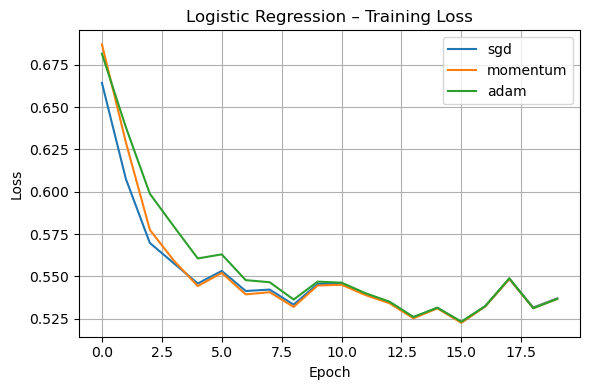

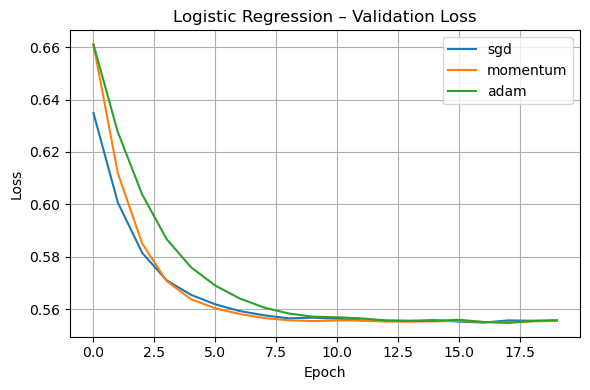

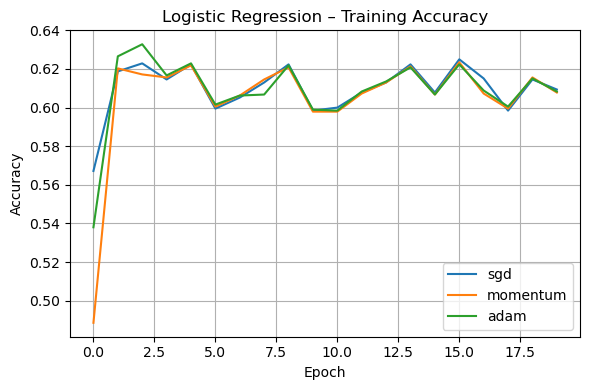

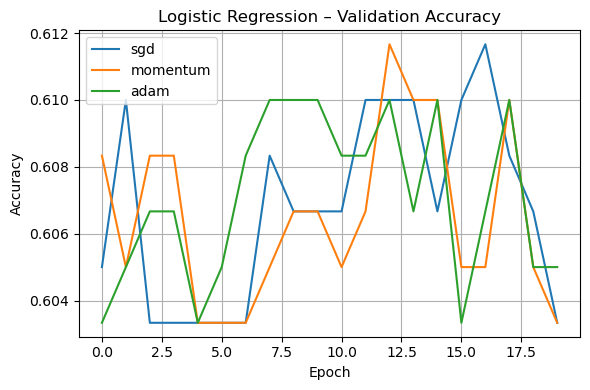

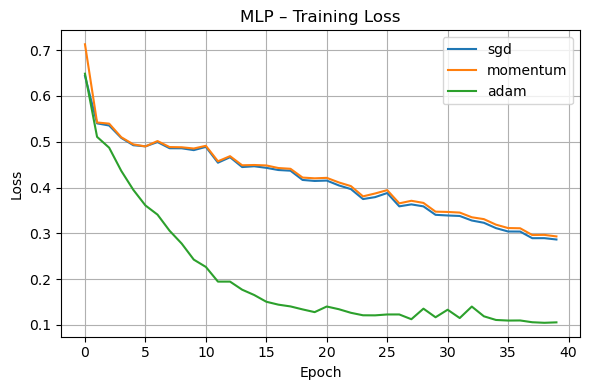

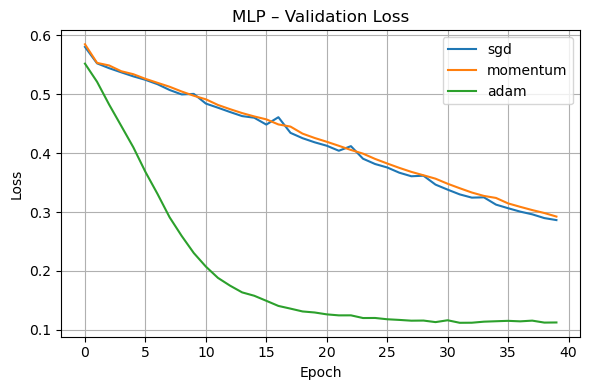

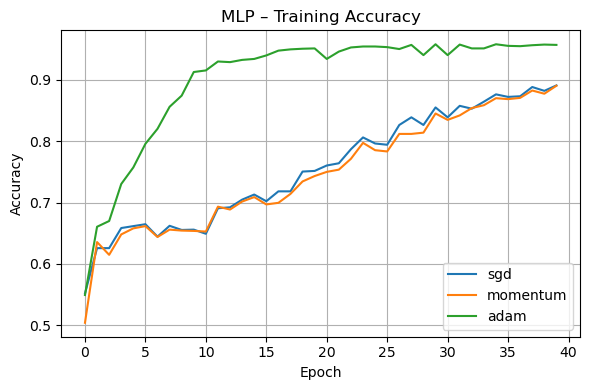

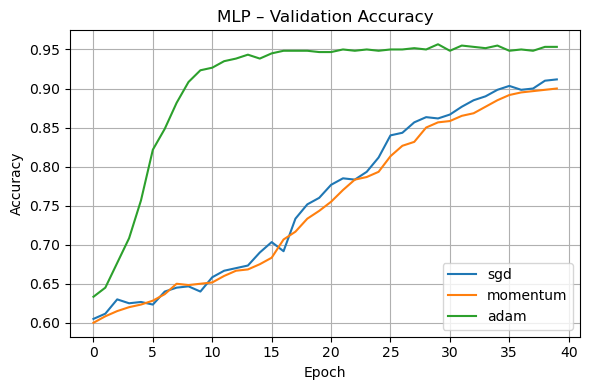

In [13]:
def plot_history(histories: dict, key: str, title: str, ylabel: str) -> None:
    """
    Plot a metric (loss or accuracy) over epochs for several optimisers.
    """
    plt.figure(figsize=(6, 4))
    for name, hist in histories.items():
        plt.plot(hist[key], label=name)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Logistic regression plots
plot_history(logreg_histories, "train_loss", "Logistic Regression – Training Loss", "Loss")
plot_history(logreg_histories, "val_loss",   "Logistic Regression – Validation Loss", "Loss")
plot_history(logreg_histories, "train_acc",  "Logistic Regression – Training Accuracy", "Accuracy")
plot_history(logreg_histories, "val_acc",    "Logistic Regression – Validation Accuracy", "Accuracy")

# MLP plots
plot_history(mlp_histories, "train_loss", "MLP – Training Loss", "Loss")
plot_history(mlp_histories, "val_loss",   "MLP – Validation Loss", "Loss")
plot_history(mlp_histories, "train_acc",  "MLP – Training Accuracy", "Accuracy")
plot_history(mlp_histories, "val_acc",    "MLP – Validation Accuracy", "Accuracy")



When you run these plotting functions you will observe distinct behaviours:

**Logistic regression**: all optimisers converge similarly because the problem is convex; the training and validation accuracies stabilise around 60 %.  Increasing the learning rate might affect the speed but not the final accuracy.
**MLP**: the accuracies rise much higher.  Adam typically converges the fastest, followed by momentum, and then plain SGD.  You should see validation accuracies exceeding 90 % with a hidden layer of moderate size.

## 14. Conclusion

**Data preparation** – creating a nonlinear toy dataset, splitting it properly, standardising features and iterating over mini‑batches.
**Model implementation** – writing logistic regression and a one‑hidden‑layer MLP using only NumPy.
**Optimisation** – implementing SGD, momentum and Adam to update parameters based on computed gradients.
**Training and evaluation** – running experiments, collecting metrics and plotting the results.

Linear models cannot solve highly nonlinear problems; adding a hidden layer and a nonlinearity (like ReLU) enables the model to **bend** the decision boundary.

> Different optimisers have different personalities: 
> **SGD** is simple but noisy; 
> **Momentum** smooths the updates; 
> **Adam** adapts the step sizes and often converges faster.
> Plotting both loss and accuracy gives a more complete picture of what the model is learning: loss measures confidence of the predictions whereas accuracy measures correctness.

Feel free to experiment with different hidden sizes, learning rates, numbers of epochs and noise levels to see how they affect the learning curves.  Each change will teach you something about how neural networks and optimisers behave.